## Imports
- Sets up Keras Core backend to use Tensorflow.

In [1]:
import numpy as np
import os
# need to define backend before importing Keras
# to change a backend, you will have to restart the kernel
os.environ["KERAS_BACKEND"] = "jax"
import keras_core as keras
from keras_core import layers
from keras_core import ops
import shutil
from PIL import Image
import keras_cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Using JAX backend.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

The data is organized under the `./../sunglasses-dataset` folder with one subfolder per class (`sunglasses` and `no_sunglasses`).
```
sunglasses-dataset
├── sunglasses
│   ├── phoebe_left_angry_sunglasses_2.pgm
│   ├── phoebe_right_sad_sunglasses.pgm
│   ...
├── no_sunglasses
│   ├── mitchell_straight_happy_open_4.pgm
│   ├── phoebe_straight_neutral_open_4.pgm
│   ├── phoebe_up_happy_open_2.pgm
├── ...
```

In [2]:
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    directory='./../sunglasses-dataset/',
    labels="inferred",
    label_mode='categorical',
    batch_size=32,
    image_size=(64, 64),
    validation_split=0.2,
    subset="both",
    seed=0
)

Found 624 files belonging to 2 classes.
Using 500 files for training.
Using 124 files for validation.


## Visualize Dataset
Viewing the images within the dataset

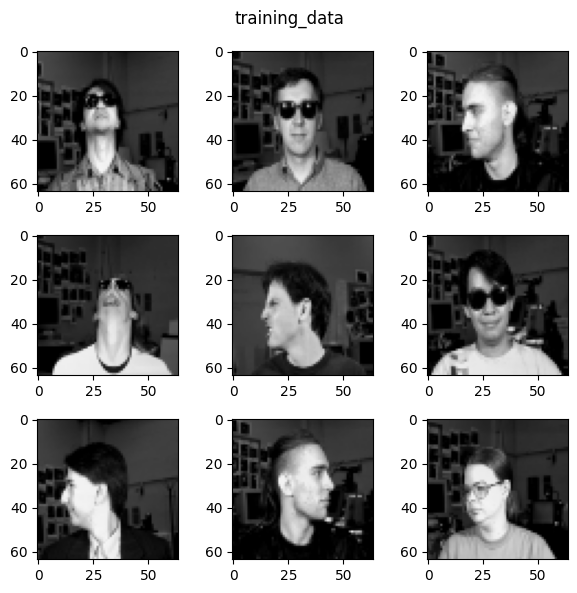

In [3]:
def plot_image_grid(images, grid=3, title=None):
    fig, axes = plt.subplots(grid,grid, figsize=(grid*2,grid*2))
    for i in range(grid):
        for j in range(grid):
            if i*grid + j < len(images):
                axes[i][j].imshow(images[i*grid + j].astype('uint8'))
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    
X = np.concatenate([x for x, y in train_dataset], axis=0)
plot_image_grid(X, title="training_data")

## Build Classification Model
Image classification problem with require `layers.Conv2D()`, a flattening layer like `layers.Flatten()`, and a `layers.Dense()` to coerce the output to be a probability distribution over two classes.

In [4]:
model = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)        │        448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 16)          │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 576)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 2)                 │      1,154 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 8,562 (33.45 KB)

 Trainable params: 8,562 (33.45 KB)

 Non-trainable params: 0 (0.00 B)

## Train Classification Model
Define the optimizer and loss to use for the training process with `model.compile()`, and run the training loop on the dataset with `model.fit()`

In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(5e-4),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
)

In [6]:
# Should be able to get at least 80% for validation accuracy
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5681 - loss: 2.5894 - val_accuracy: 0.6210 - val_loss: 1.1521
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6214 - loss: 1.1424 - val_accuracy: 0.6371 - val_loss: 0.9310
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6969 - loss: 0.6907 - val_accuracy: 0.6855 - val_loss: 0.7425
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7719 - loss: 0.4823 - val_accuracy: 0.7097 - val_loss: 0.7061
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8063 - loss: 0.3998 - val_accuracy: 0.7419 - val_loss: 0.5634
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8500 - loss: 0.3289 - val_accuracy: 0.7742 - val_loss: 0.5534
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8812 - loss: 0.2900 - val_accuracy: 0.8306 - val_loss: 0.4974
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8976 - loss: 0.2164 - val_accuracy: 0.8548 - v

In [7]:
# View the training history through a pandas.DataFrame
history_df = pd.DataFrame(history.history)
history_df.head(3)

,accuracy,loss,val_accuracy,val_loss
0,0.572,2.122890,0.620968,1.152080
1,0.640,0.994135,0.637097,0.930951
2,0.708,0.644715,0.685484,0.742461


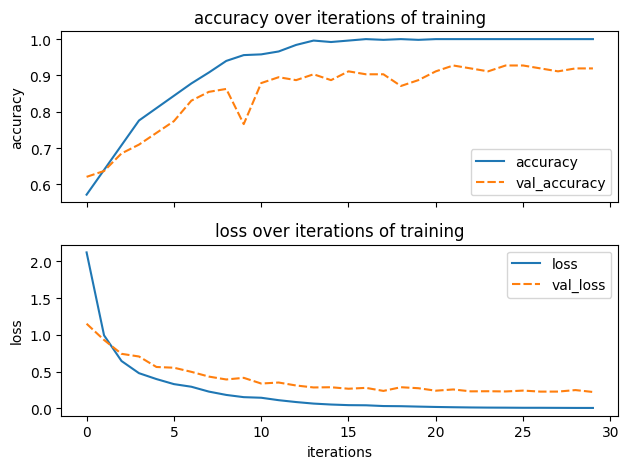

In [8]:
# Helper function to plot accuracy and loss (training history) of the run
def plot_history(history_df):
    fig, axes = plt.subplots(2,1, sharex=True)
    sns.lineplot(data=history_df[["accuracy", "val_accuracy"]], ax=axes[0]).set(
        title="accuracy over iterations of training",
        xlabel="iterations",
        ylabel="accuracy"
    )
    sns.lineplot(data=history_df[["loss", "val_loss"]], ax=axes[1]).set(
        title="loss over iterations of training",
        xlabel="iterations",
        ylabel="loss"
    )
    plt.tight_layout()
plot_history(history_df)

## Analyze the Model
Running `model.evaluate()`, plotting a confusion matrix, and visualizing incorrectly classified images

In [9]:
# Evaluate the model on the validation dataset 
# a.k.a. running the trained model without updating the weights
model.evaluate(validation_dataset);

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9427 - loss: 0.1397 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


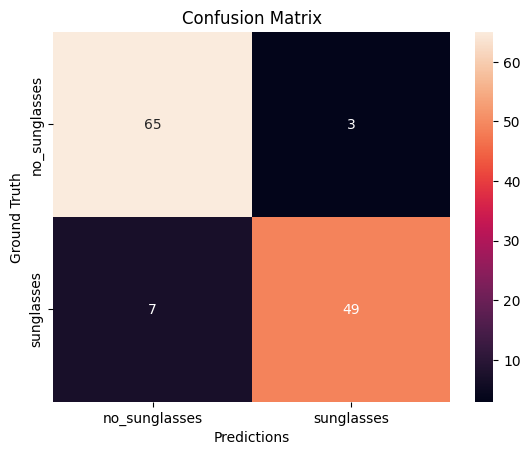

In [10]:
# Plotting code for confusion matrix
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)))
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            matrix[i][j] = np.count_nonzero((y_true == label_true) & (y_pred == label_pred))
    return matrix
        
def get_confusion_matrix(model, dataset):
    y_true = np.argmax(np.concatenate([y for x, y in dataset], axis=0), axis=1)
    y_pred = np.argmax(model.predict(dataset), axis=1)
    confusion_mat = confusion_matrix(y_true, y_pred)
    confusion_df = pd.DataFrame(
        confusion_mat, 
        columns=["no_sunglasses", "sunglasses"], 
        index=["no_sunglasses", "sunglasses"]
    )
    sns.heatmap(confusion_df, annot=True).set(
        title="Confusion Matrix",
        xlabel="Predictions",
        ylabel="Ground Truth"
    )
get_confusion_matrix(model, validation_dataset)

In [11]:
y_true = np.argmax(np.concatenate([y for x, y in validation_dataset], axis=0), axis=1)
X = np.concatenate([x for x, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)
predictions = list(zip(X, y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


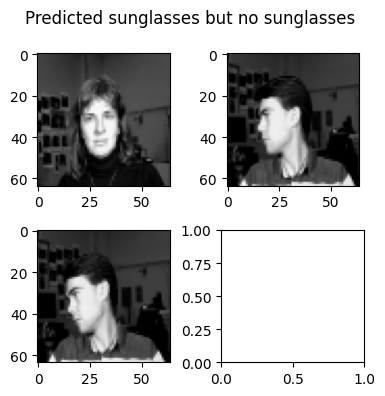

In [12]:
# predicted to be wearing sunglasses but isn't wearing sunglasses
predictions1 = [image for image, y_true, y_pred in predictions if y_true == 0 and y_pred == 1]
plot_image_grid(predictions1, grid=2, title="Predicted sunglasses but no sunglasses")

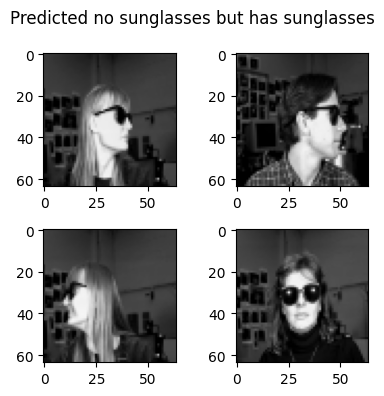

In [13]:
# predicted to not have sunglasses sunglasses but is wearing sunglasses
predictions2 = [image for image, y_true, y_pred in predictions if y_true == 1 and y_pred == 0]
plot_image_grid(predictions2, grid=2, title="Predicted no sunglasses but has sunglasses")